In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pprint

pp = pprint.PrettyPrinter(indent=4, depth=4)

# Salary Classification


In [25]:
relative_path = "tema2_SalaryPrediction/SalaryPrediction_full.csv"
df = pd.read_csv(relative_path)

# Print the first 10 rows to check if the data has been loaded and what features are present
df.head(10)

,fnl,hpw,relation,gain,country,job,edu_int,years,loss,work_type,partner,edu,gender,race,prod,gtype,money
0,264627,40.0,NotM,0,United-States,Adm-clerical,10,38,0,Priv,D,SC,NaN,White,77,DC,<=50K
1,151369,40.0,NotF,0,United-States,Craft-repair,9,62,0,LGov,NM,HSG,M,White,87,AC,<=50K
2,188615,60.0,H,0,United-States,Sales,13,42,0,SelfInc,MCS,B,M,White,77,AC,>50K
3,151089,55.0,H,0,United-States,Exec-managerial,10,41,2415,SelfInc,MCS,SC,M,White,107,AC,>50K
4,177625,40.0,NotF,0,United-States,Machine-op-inspct,9,25,0,Priv,NM,HSG,M,White,57,AC,<=50K
5,444089,40.0,NotF,0,United-States,Sales,7,56,0,Priv,D,11,F,White,62,DC,<=50K
6,101320,75.0,NotF,0,United-States,Exec-managerial,14,49,0,Priv,D,M,F,White,62,DC,<=50K
7,35411,40.0,NotF,0,United-States,Machine-op-inspct,9,59,0,Priv,W,HSG,F,White,82,DC,<=50K
8,93235,25.0,OwnC,0,United-States,Other-service,8,17,1721,Priv,NM,12,F,White,67,DC,<=50K
9,232855,37.0,NotM,0,United-States,Other-service,10,34,0,Priv,S,SC,F,Black,52,DC,<=50K


In [26]:
# Check the shape of the dataframe
print(df.shape)

(9999, 17)


In [27]:
# Data type for each column
for col in df.columns:
    print(col, "is of type", type(df[col][0]))

fnl is of type <class 'numpy.int64'>
hpw is of type <class 'numpy.float64'>
relation is of type <class 'str'>
gain is of type <class 'numpy.int64'>
country is of type <class 'str'>
job is of type <class 'str'>
edu_int is of type <class 'numpy.int64'>
years is of type <class 'numpy.int64'>
loss is of type <class 'numpy.int64'>
work_type is of type <class 'str'>
partner is of type <class 'str'>
edu is of type <class 'str'>
gender is of type <class 'float'>
race is of type <class 'str'>
prod is of type <class 'numpy.int64'>
gtype is of type <class 'str'>
money is of type <class 'str'>


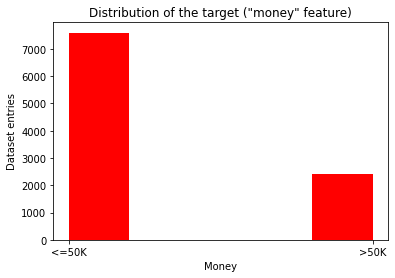

'We may observe that there is a lot more data for <= 50k salaries'

In [28]:
# Analyzing the target feature
target = df['money']

plt.hist(target, color = 'red', bins = 5)
plt.xlabel('Money')
plt.ylabel('Dataset entries')
plt.title('Distribution of the target ("money" feature)')
plt.show()

"""We may observe that there is a lot more data for <= 50k salaries"""

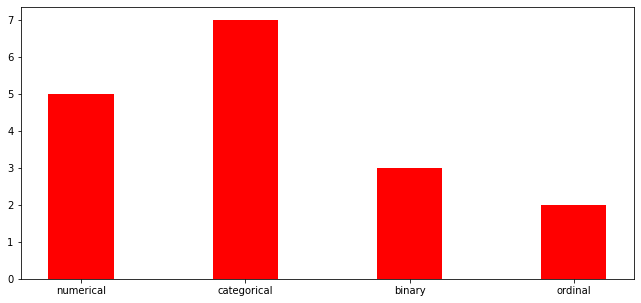

{   'binary': {'attributes': ['gender', 'gtype', 'money'], 'size': 3},
    'categorical': {   'attributes': [   'relation',
                                         'country',
                                         'job',
                                         'work_type',
                                         'partner',
                                         'edu',
                                         'race'],
                       'size': 7},
    'numerical': {   'attributes': ['fnl', 'hpw', 'gain', 'loss', 'prod'],
                     'size': 5},
    'ordinal': {'attributes': ['edu_int', 'years'], 'size': 2}}


In [29]:
def get_features_types(df):
    types = ["numerical", "categorical", "binary", "ordinal"]
    features = {k: {"attributes": [], "size": 0} for k in types}

    # Considering "edu_int" and "years" to be ordinal features  (by manual inspecting the dataframe)
    features["ordinal"] = {"attributes": ["edu_int", "years"], "size": 2}

    for col in df.columns:
        if col in features["ordinal"]["attributes"]:
            continue

        if df[col].nunique() == 2:
            type = "binary"
        elif pd.api.types.is_numeric_dtype(df[col]):
            type = "numerical"
        else:
            type = "categorical"
        
        features[type]["attributes"].append(col)
        features[type]["size"] += 1

    return features

features = get_features_types(df)

plt.figure(figsize = (11, 5))
plt.bar(features.keys(), [v["size"] for v in features.values()], width = .4, color = 'red')
plt.show()

pp.pprint(features)

### Numerical features

In [39]:
numerical_combined_stats_df = pd.DataFrame()

for numerical_feature in features["numerical"]["attributes"]:
    statistics = df[numerical_feature].describe(percentiles=[0.25, 0.5, 0.75]).T
    missing = df[numerical_feature].isnull().sum()
    
    # Combine statistics and missing values
    stats_dict = {
        'num_examples': statistics['count'],
        'mean': statistics['mean'],
        'std_dev': statistics['std'],
        'min': statistics['min'],
        '25th_percentile': statistics['25%'],
        'median': statistics['50%'],
        '75th_percentile': statistics['75%'],
        'max': statistics['max'],
        'missing': missing
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[numerical_feature])
    numerical_combined_stats_df = pd.concat([numerical_combined_stats_df, stats_df])

display(numerical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'mean': '{:,.2f}',
    'std_dev': '{:,.2f}',
    'min': '{:,.2f}',
    '25th_percentile': '{:,.2f}',
    'median': '{:,.2f}',
    '75th_percentile': '{:,.2f}',
    'max': '{:,.2f}',
    'missing': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,mean,std_dev,min,25th_percentile,median,75th_percentile,max,missing
fnl,"9,999","190,352.90","106,070.86","19,214.00","118,282.50","178,472.00","237,311.00","1,455,435.00",0
hpw,"9,199",40.42,12.52,1.00,40.00,40.00,45.00,99.00,800
gain,"9,999",979.85,"7,003.80",0.00,0.00,0.00,0.00,"99,999.00",0
loss,"9,999",84.11,394.04,0.00,0.00,0.00,0.00,"3,770.00",0
prod,"9,999","2,014.93","14,007.60",-28.00,42.00,57.00,77.00,"200,125.00",0


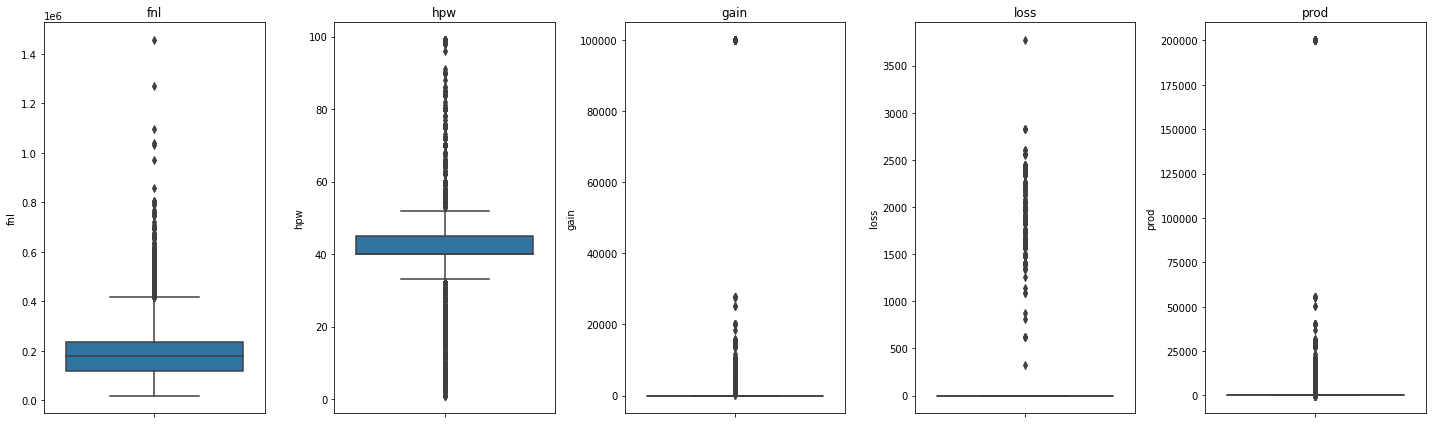

In [31]:
# Create subplots for boxplots
fig, axes = plt.subplots(nrows=1, ncols=len(features["numerical"]["attributes"]), figsize=(20, 6))

for i, numerical_feature in enumerate(features["numerical"]["attributes"]):
    sns.boxplot(data=df, y=numerical_feature, ax=axes[i])
    axes[i].set_title(numerical_feature)

plt.tight_layout()
plt.show()

### Categorical Features

In [41]:
categorical_combined_stats_df = pd.DataFrame()

for categorical_feature in features["categorical"]["attributes"]:
    non_missing_count = df[categorical_feature].notnull().sum()
    unique_count = df[categorical_feature].nunique()
    
    # Combine statistics into a dictionary
    stats_dict = {
        'num_examples': non_missing_count,
        'num_unique': unique_count
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[categorical_feature])
    categorical_combined_stats_df = pd.concat([categorical_combined_stats_df, stats_df])

display(categorical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'num_unique': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,num_unique
relation,"9,999",6
country,"9,999",41
job,"9,999",14
work_type,"9,999",9
partner,"9,999",7
edu,"9,999",16
race,"9,999",5


In [ ]:
for feature in features["categorical"]["attributes"]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()